In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# EX model defining and training
---

In [2]:
import joblib
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import drive.MyDrive.scripts.utils as util

from datetime import datetime
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer

warnings.filterwarnings('ignore')

## Configuration parameters

In [6]:
''' DATASET
-------------------------------------------------------
'''

# Dataset size
SIZE = 'month' # Alternative: 'day'

# Insert preferred ship and date here
FILE = {
    'ship': '13218',
    'year': '2023',
    'month': '9',
    'day': '4'
}

if (SIZE == 'month'):
  SHORT = f'{FILE["ship"]}-{FILE["year"]}-{FILE["month"]}'
else:
  SHORT = f'{FILE["ship"]}-{FILE["year"]}-{FILE["month"]}-{FILE["day"]}'


# NB: Changing this will alter what attributes the model will be trained to predict
y_attr = ['01EX', '02EX', '03EX', '04EX', '05EX', '06EX', '07EX', '08EX']

# NB: Changing this will alter what attributes the model will receive as input
x_attr = ['21EL', '20EL', '25EL', '87XS', '96FG', '31EL', '31EL_LIM', '78XS', '82XS']





''' MODEL
-------------------------------------------------------
'''

# Model version
VERSION = 'v1'

# Model architecture
ARCHITECTURE = 'LSTM'

# Prediction tag name
TAG_NAME = 'EX'

# Scaler: Active scaler
SCALING_ALGORITHM = 'minmax'
SCALER_PATH       = '/content/drive/MyDrive/scalers/'
SCALER_NAME       = f'{TAG_NAME}-{SCALING_ALGORITHM}-Dataset[{SHORT}]'

# Model: Input and output attributes
X_ATTRIBUTES = ['87XS']
Y_ATTRIBUTES = y_attr

# Training: Early callback monitors
CALLBACK_LISTENERS = ['loss', 'val_loss']
CALLBACK_PATIENCE  = 5                   # [ 5, 10, 15, 20]

# Model: Compilation
TEST_SIZE_PROPORTION = 0.2
LSTM_LAYER_1_UNITS   = 64
LSTM_LAYER_2_UNITS   = 128
DROPOUT              = 0.25
OPTIMIZER            = 'rmsprop'  # Look into other optimizer functions
LOSS_FUNCTION        = 'mse'

# Training: Epochs and batch size
EPOCHS     = 15                           # [15, 20, 25, 60]
BATCH_SIZE = 64                           # [64, 16, 32, 64]

# Path to model directory
DIR = '/content/drive/MyDrive/models/'





''' OTHER
-------------------------------------------------------
'''

# Getting current date
DATE = datetime.today().strftime('%Y-%m-%d')

# Decimal place to round
ROUND = 3

## Importing dataset

__All attributes except 01EX, 02EX, ..., 08EX:__

```python
x_attr = [
    '21EL', '20EL', '25EL', '87XS', '96FG', '31EL', '31EL_LIM',
    '78XS', '82XS', '10EX', '11EX', '12EX', '05HT', '06HT', '10HT',
    '05LT', '06LT', '10LT', '05NC', '10NC', '05LO', '06LO', '10LO',
    '11LO', '13LO', '14LO', '05CA', '08CA', '21CA', '10SA', '14SA',
    '05DO', '10DO', '12DO', '13DO'
]

x_attr = ['21EL', '20EL', '25EL', '87XS', '96FG', '31EL', '31EL_LIM', '78XS', '82XS']
```

In [7]:
if SIZE == 'month':
  try:
    df = util.open_dataset_at_month(FILE)
  except:
    !pip install fastparquet
    df = util.open_dataset_at_month(FILE)
else:
  try:
    df = util.open_dataset_at_date(FILE)
  except:
    !pip install fastparquet
    df = util.open_dataset_at_date(FILE)
df

,B21CA,14LO,24EL,07HT,54XA,55XA,57XA,16DO,15LO,05XS,...,05EX,01EX,06LO,06EX,07EX,08EX,05HT,87XS,missingMsgCount,frequencyMsgCount
time,,,,,,,,,,,,,,,,,,,,,
2023-09-01 00:00:00,0.052,4.572,5.288,71.2,5.0,5.0,5.0,6.826,4.567,False,...,246.0,218.0,66.0,233.0,225.0,197.0,70.0,0.000000,NaN,NaN
2023-09-01 00:00:01,0.052,4.502,5.168,71.2,5.0,5.0,5.0,7.341,4.553,False,...,246.0,218.0,66.0,233.0,225.0,197.0,70.0,0.000000,NaN,NaN
2023-09-01 00:00:02,0.047,4.514,5.240,71.2,5.0,5.0,5.0,7.260,4.510,False,...,246.0,218.0,66.0,233.0,225.0,197.0,70.0,0.000000,NaN,NaN
2023-09-01 00:00:03,0.047,4.485,5.216,71.2,5.0,5.0,5.0,7.543,4.416,False,...,245.0,218.0,66.0,233.0,225.0,197.0,69.9,0.000000,NaN,NaN
2023-09-01 00:00:04,0.054,4.485,5.312,71.1,5.0,5.0,5.0,7.899,4.495,False,...,245.0,218.0,66.0,233.0,225.0,197.0,69.9,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-30 23:59:55,0.550,4.372,11.088,79.0,5.0,5.0,5.0,7.138,4.423,False,...,332.0,335.0,68.0,339.0,332.0,323.0,76.3,37.331078,NaN,NaN
2023-09-30 23:59:56,0.538,4.343,11.032,79.0,5.0,5.0,5.0,6.797,4.293,False,...,332.0,335.0,68.0,339.0,332.0,323.0,76.3,36.486485,NaN,NaN
2023-09-30 23:59:57,0.531,4.381,10.968,79.0,5.0,5.0,5.0,7.439,4.416,False,...,332.0,335.0,68.0,339.0,332.0,323.0,76.3,35.641890,NaN,NaN


## Data cleanup and processing

### Fill cells containing <code>NaN</code> with attribute mean

In [8]:
# This code was made by ChatGPT
df.fillna(df.mean(), inplace=True)

### Removing attributes with constant values and producing modified dataset

In [9]:
df, x_attr, y_attr, controlled_parameters = util.produce_modified_dataset(df, x_attr, y_attr)
df

,21EL,25EL,87XS,01EX,02EX,03EX,04EX,05EX,06EX,07EX,08EX
time,,,,,,,,,,,
2023-09-01 00:00:00,902.0,11580.0,0.000000,218.0,228.0,205.0,212.0,246.0,233.0,225.0,197.0
2023-09-01 00:00:01,903.0,11580.0,0.000000,218.0,227.0,205.0,212.0,246.0,233.0,225.0,197.0
2023-09-01 00:00:02,901.0,11580.0,0.000000,218.0,227.0,205.0,212.0,246.0,233.0,225.0,197.0
2023-09-01 00:00:03,902.0,11580.0,0.000000,218.0,227.0,205.0,212.0,245.0,233.0,225.0,197.0
2023-09-01 00:00:04,901.0,11580.0,0.000000,218.0,227.0,205.0,212.0,245.0,233.0,225.0,197.0
...,...,...,...,...,...,...,...,...,...,...,...
2023-09-30 23:59:55,901.0,21110.0,37.331078,335.0,342.0,341.0,323.0,332.0,339.0,332.0,323.0
2023-09-30 23:59:56,902.0,21010.0,36.486485,335.0,342.0,341.0,323.0,332.0,339.0,332.0,323.0
2023-09-30 23:59:57,899.0,20890.0,35.641890,335.0,342.0,341.0,323.0,332.0,339.0,332.0,323.0


### Filtering

In [10]:
df = util.remove_rows_at(df, 'df["21EL"] >= 885')
df = util.remove_rows_at(df, 'df["25EL"] >= 14000')

## Qualitative dataset exploration

### Exploring correlating relationships

__For larger heatmaps__:

```python
correlation_matrix = df.corr()

title = 'Correlation Heatmap'
ship = f'\nShip: {FILE["ship"]}'
date = f'\nDate: {FILE["year"]}-{FILE["month"]}-{FILE["day"]}'

plt.figure(figsize=(50, 40))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', annot_kws={"fontsize": 22})
plt.title(title + ship + date)
plt.xticks(rotation=45, fontsize=20)  
plt.yticks(rotation=45, fontsize=18)
plt.show()
```

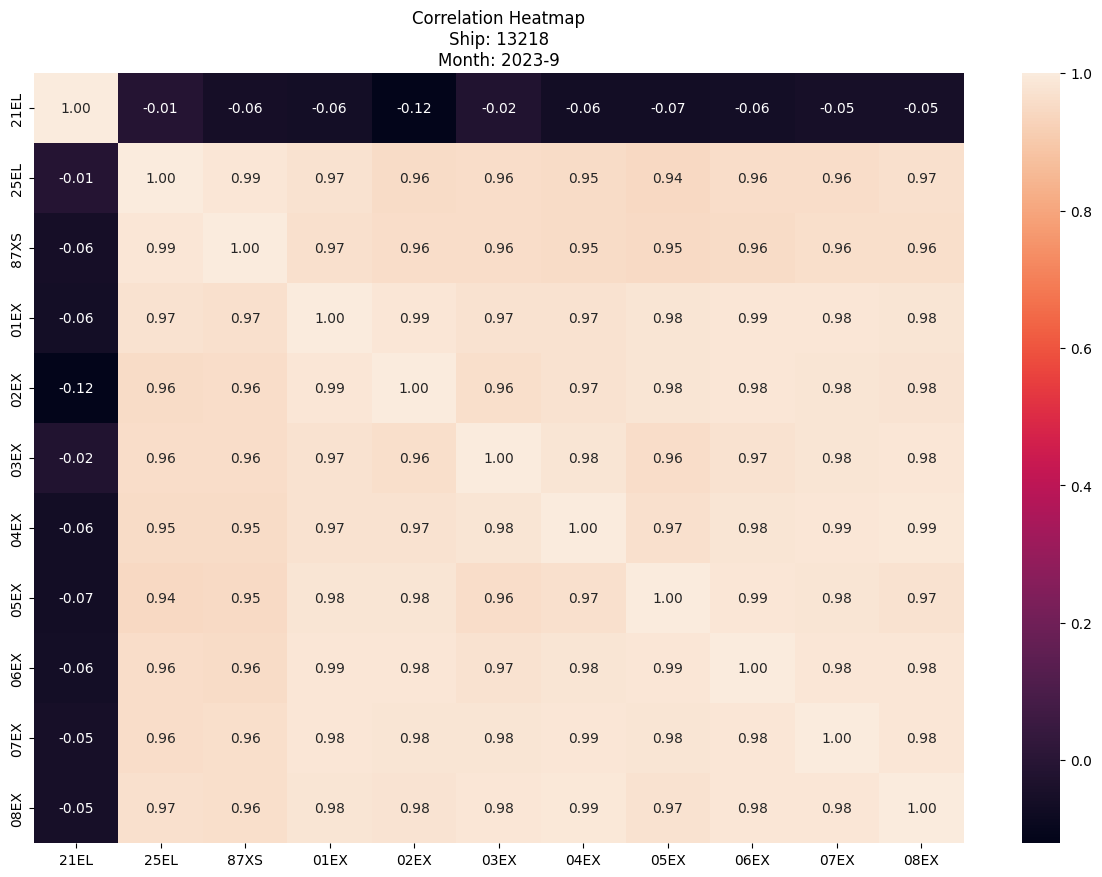

In [11]:
correlation_matrix = df.corr()

title = 'Correlation Heatmap'
ship = f'\nShip: {FILE["ship"]}'

if SIZE == 'month':
  date = f'\nMonth: {FILE["year"]}-{FILE["month"]}'
else:
  date = f'\nDate: {FILE["year"]}-{FILE["month"]}-{FILE["day"]}'

plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f')
plt.title(title + ship + date)
plt.show()

## Model creation

### Designing and training the model

Epoch 1/15
25635/25635 [==============================] - 194s 7ms/step - loss: 2455.7102 - val_loss: 42.9849
Epoch 2/15
25635/25635 [==============================] - 175s 7ms/step - loss: 169.5315 - val_loss: 48.1378
Epoch 3/15
25635/25635 [==============================] - 183s 7ms/step - loss: 163.9642 - val_loss: 41.9661
Epoch 4/15
25635/25635 [==============================] - 172s 7ms/step - loss: 159.1418 - val_loss: 43.1565
Epoch 5/15
25635/25635 [==============================] - 172s 7ms/step - loss: 154.4374 - val_loss: 39.3991
Epoch 6/15
25635/25635 [==============================] - 178s 7ms/step - loss: 149.7835 - val_loss: 43.0588
Epoch 7/15
25635/25635 [==============================] - 179s 7ms/step - loss: 145.7628 - val_loss: 38.6950
Epoch 8/15
25635/25635 [==============================] - 176s 7ms/step - loss: 141.0636 - val_loss: 40.9677
Epoch 9/15
25635/25635 [==============================] - 177s 7ms/step - loss: 136.6491 - val_loss: 42.9810
Epoch 10/15
25635/

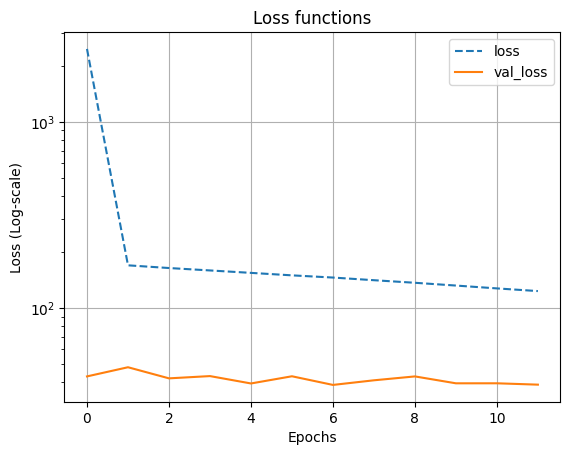

In [12]:
Y_ATTRIBUTES = y_attr

# Setting desired input and output attributes
num_attributes_x = len(X_ATTRIBUTES)
num_attributes_y = len(Y_ATTRIBUTES)
timesteps = 1

dfx = df[X_ATTRIBUTES]
dfy = df[Y_ATTRIBUTES]


# Scaling algorithms
SCALERS = {
    'standard':     StandardScaler().fit(dfx),
    'minmax':       MinMaxScaler(feature_range=(0, 1)).fit(dfx),     # This scaler has given the best results
    'robust':       RobustScaler().fit(dfx),
    'normalizer':   Normalizer().fit(dfx)
}

# Specifying which scaler to use
scaler = SCALERS[ SCALING_ALGORITHM ]        # NB: Scaler must be the same as the one used for training
joblib.dump(scaler, f'{SCALER_PATH}{SCALER_NAME}.joblib') # This code was made by ChatGPT
dfx = pd.DataFrame(scaler.transform(dfx))


X_train, X_test, y_train, y_test = train_test_split(dfx, dfy, test_size=TEST_SIZE_PROPORTION, shuffle=False)

X_train = X_train.to_numpy().reshape(X_train.shape[0], timesteps, num_attributes_x)
y_train = y_train.to_numpy().reshape(y_train.shape[0], timesteps, num_attributes_y)

X_test  =  X_test.to_numpy().reshape(X_test.shape[0],  timesteps, num_attributes_x)
y_test  =  y_test.to_numpy().reshape(y_test.shape[0],  timesteps, num_attributes_y)


# Define LSTM model
model = Sequential()
model.add( Bidirectional(LSTM(LSTM_LAYER_1_UNITS, input_shape=(timesteps, num_attributes_x), return_sequences=True)) )
model.add( Bidirectional(LSTM(LSTM_LAYER_2_UNITS, return_sequences=True)) )
model.add( Dropout(DROPOUT) )
model.add( Dense(num_attributes_y) )


# Compile the model
model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNCTION)


# Adding early stopping listeners for validation metrics
callbacks = []
for listener in CALLBACK_LISTENERS:
  callbacks.append( EarlyStopping(monitor=listener, patience=CALLBACK_PATIENCE, restore_best_weights=True) )


# Training the model
trained_model = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                  validation_data=(X_test, y_test), callbacks=callbacks)


# Plotting the loss as a function of epochs
print('\n')
plt.plot(trained_model.history['loss'],     label='loss', linestyle='dashed')
plt.plot(trained_model.history['val_loss'], label='val_loss')
plt.title('Loss functions')
plt.xlabel('Epochs')
plt.ylabel('Loss (Log-scale)')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

### Predicting 01EX, 02EX, ..., 08EX

In [13]:
# Perform predictions
predictions = model.predict(X_test)

# Split the transposed array into 8 separate arrays
print(f'\nDimensions of the array before:\t {predictions.shape}')

# Predictions are on the format (num_observations x timesteps x num_attributes_y)
# We need to convert it to the format (num_attributes_y x num_observations)
# This code was made by ChatGPT
predictions = np.transpose(predictions, (2, 1, 0))
predictions = np.array([predictions[i].flatten() for i in range(predictions.shape[0])])

print(f'Dimensions of the array after:\t {predictions.shape}')
print(f'\nPredictions:\n{predictions}')

12818/12818 [==============================] - 36s 3ms/step

Dimensions of the array before:	 (410157, 1, 8)
Dimensions of the array after:	 (8, 410157)

Predictions:
[[342.3576  337.15955 336.27945 ... 330.9182  335.39294 339.77835]
 [352.49832 347.41483 346.55243 ... 341.28125 345.68344 349.97748]
 [339.90085 336.20306 335.572   ... 331.6704  334.93457 338.0703 ]
 ...
 [345.87097 341.49255 340.74774 ... 336.17294 339.99628 343.70148]
 [336.20926 332.0285  331.316   ... 326.92285 330.59662 334.13907]
 [329.9502  324.91666 324.0635  ... 318.85745 323.20392 327.45352]]


### Comparison of mean value of predictions and actual values

In [14]:
# Preparing the actual values of 01EX, 02EX, ..., 08EX
y_test = np.transpose(y_test, (2, 1, 0))
y_test = np.array([y_test[i].flatten() for i in range(y_test.shape[0])])

print('\tActual\t\tPrediction\tDifference')
print(f'\t{42 * "-"}')

# Printing mean of actual, prediction, and the difference between them
for i in range(num_attributes_y):
  actual  = round(float(y_test[i].mean()), ROUND)
  predict = round(float(predictions[i].mean()), ROUND)
  diff    = round(abs(actual - predict), ROUND)

  print(f'{y_attr[i]}:\t{actual}\t\t{predict}\t\t{diff}')

	Actual		Prediction	Difference
	------------------------------------------
01EX:	350.011		347.838		2.173
02EX:	354.548		357.865		3.317
03EX:	348.843		343.895		4.948
04EX:	332.11		333.444		1.334
05EX:	339.986		339.843		0.143
06EX:	351.335		350.522		0.813
07EX:	341.662		340.669		0.993
08EX:	335.679		335.248		0.431


### Producing qualitative and quantitative accuracy

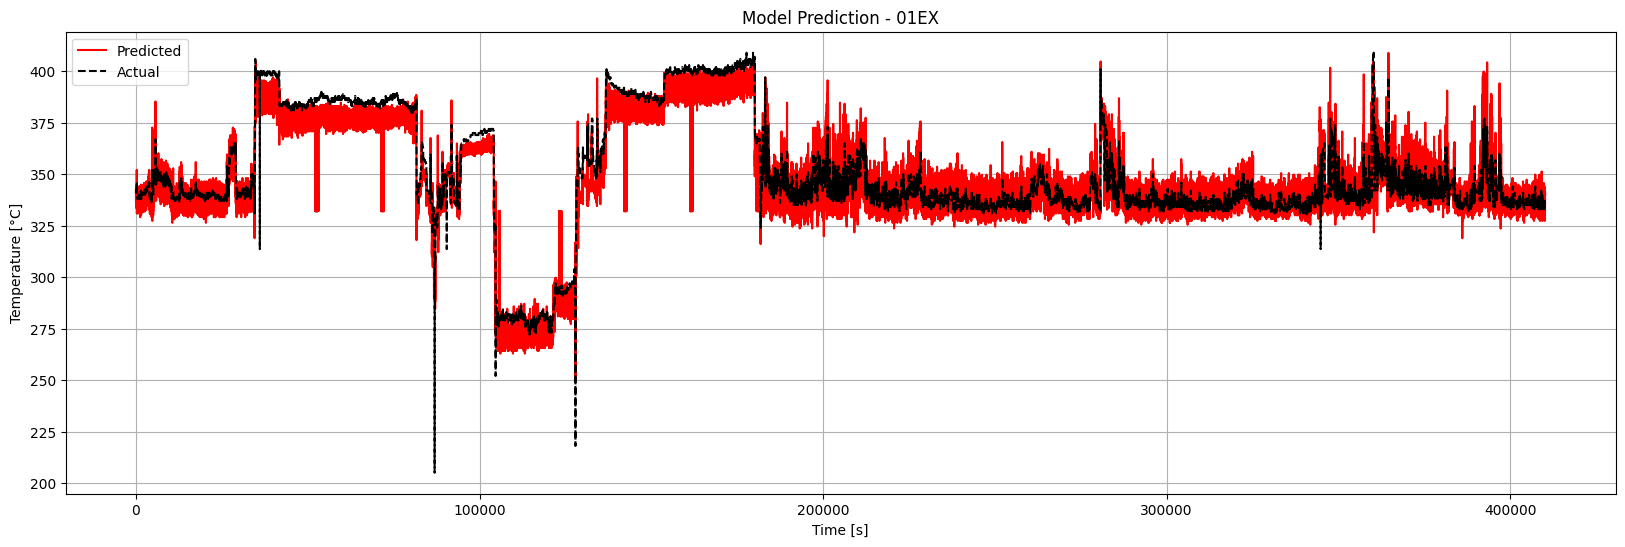


Mean Squared Error: 49.396126485483194
Root Mean Squared Error: 7.028237793749098
Mean Absolute Error: 5.310963068735313
R-squared: 0.9350159988978077 




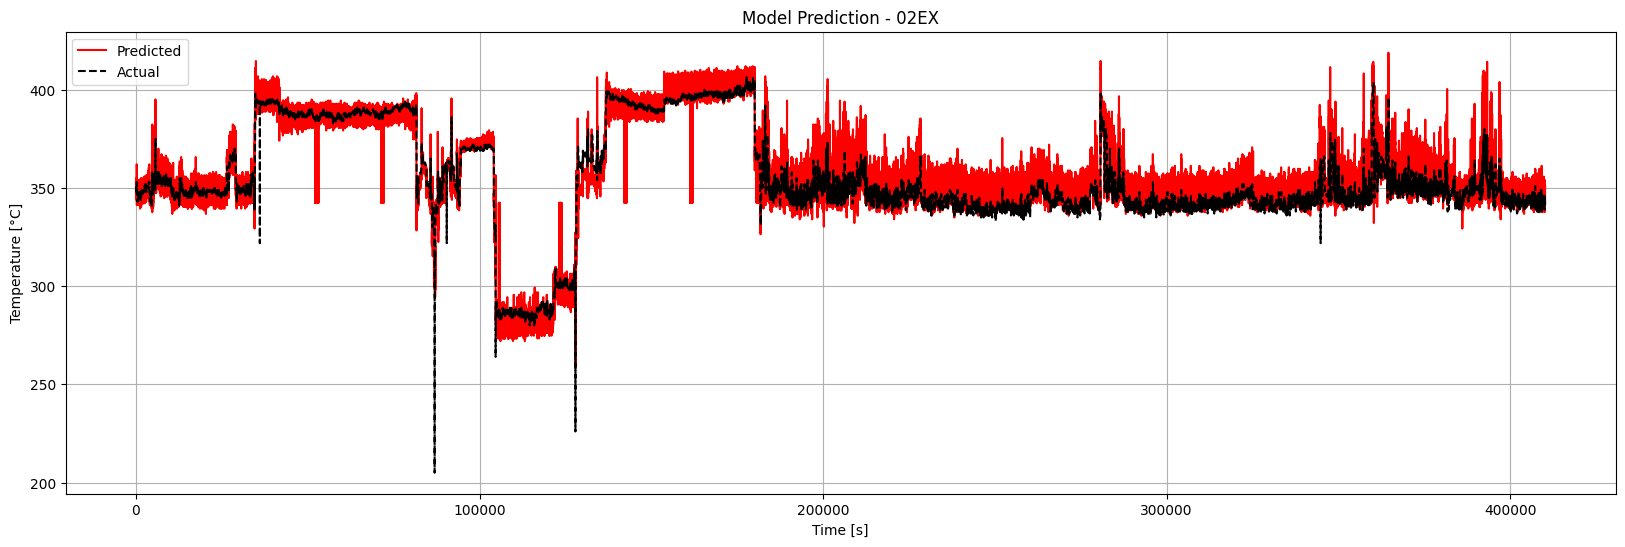


Mean Squared Error: 50.12911119437256
Root Mean Squared Error: 7.080191465940209
Mean Absolute Error: 5.418501024375734
R-squared: 0.9219824155776145 




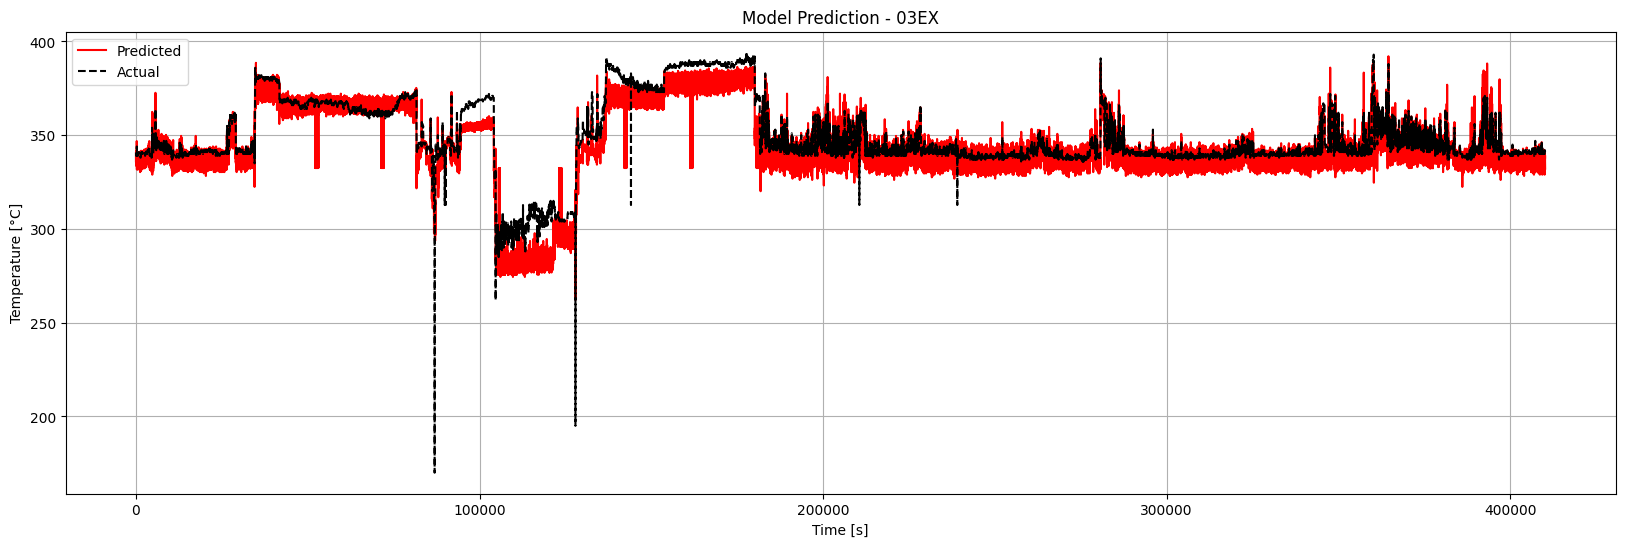


Mean Squared Error: 63.025975766702594
Root Mean Squared Error: 7.9388900840547345
Mean Absolute Error: 5.754173702681865
R-squared: 0.8277380456017267 




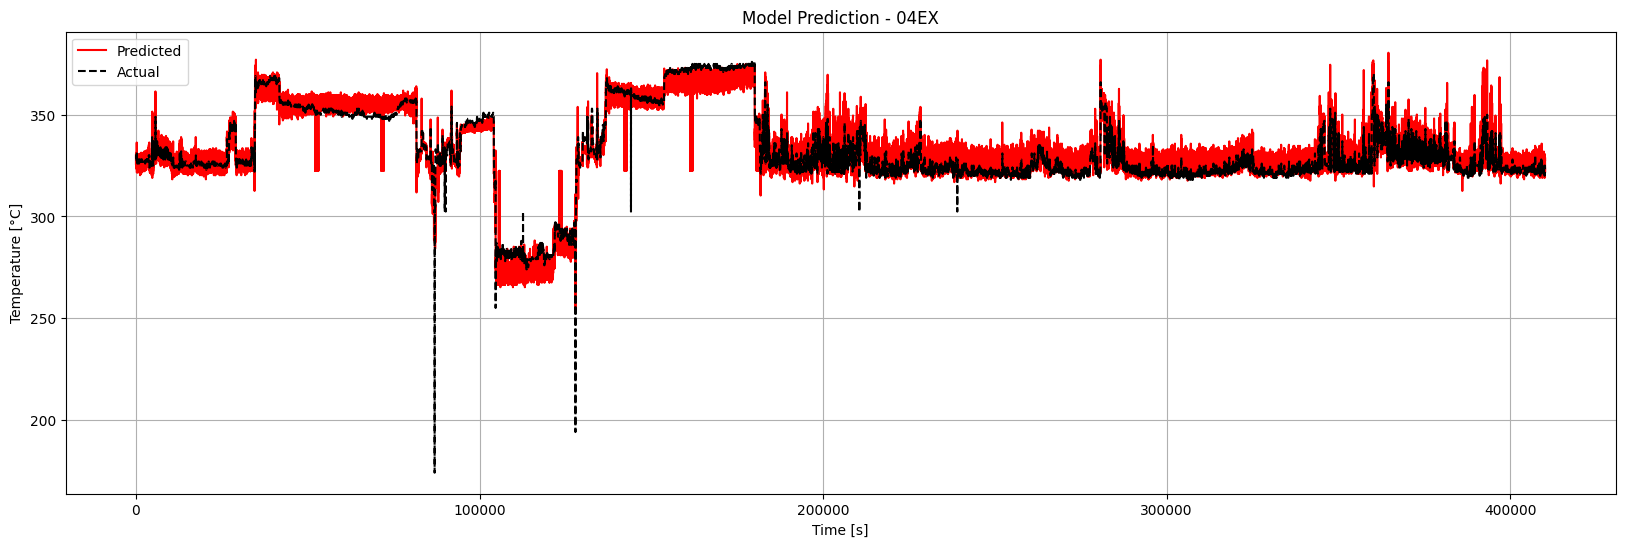


Mean Squared Error: 30.313297489457803
Root Mean Squared Error: 5.505751310171737
Mean Absolute Error: 4.316896349997086
R-squared: 0.922942087011166 




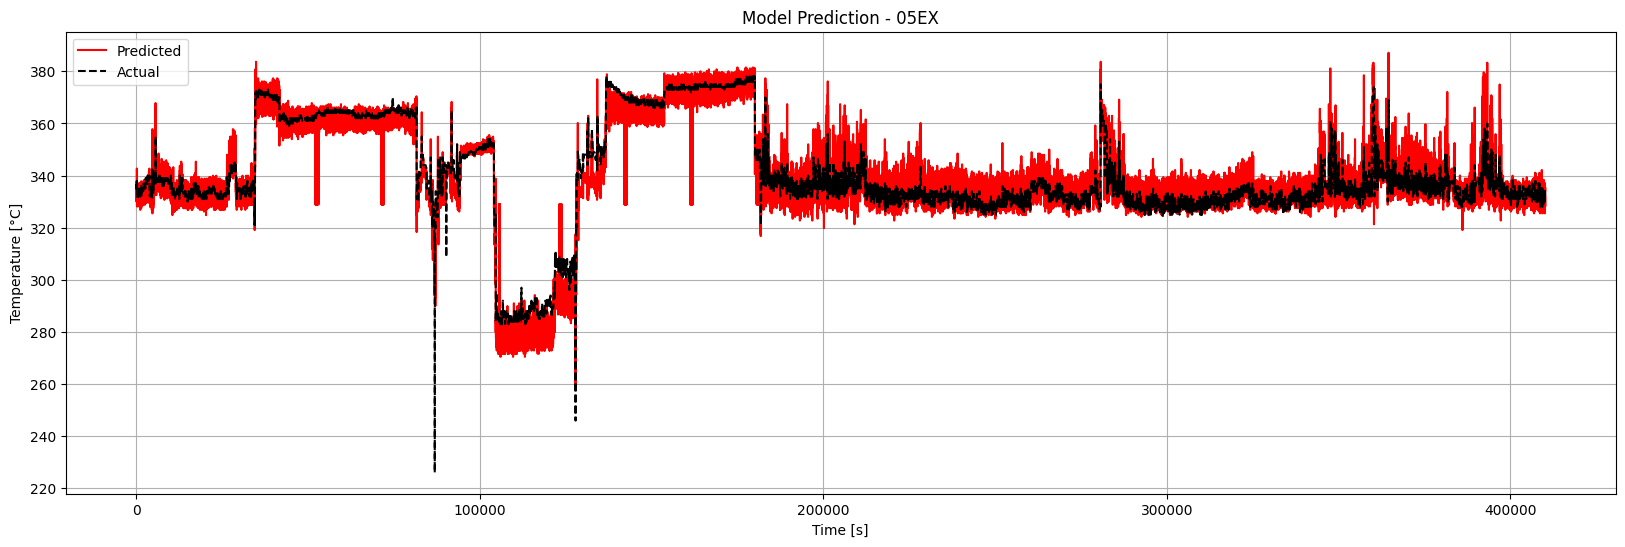


Mean Squared Error: 25.058589252534208
Root Mean Squared Error: 5.0058554965694135
Mean Absolute Error: 3.5880266225671535
R-squared: 0.9316349662037877 




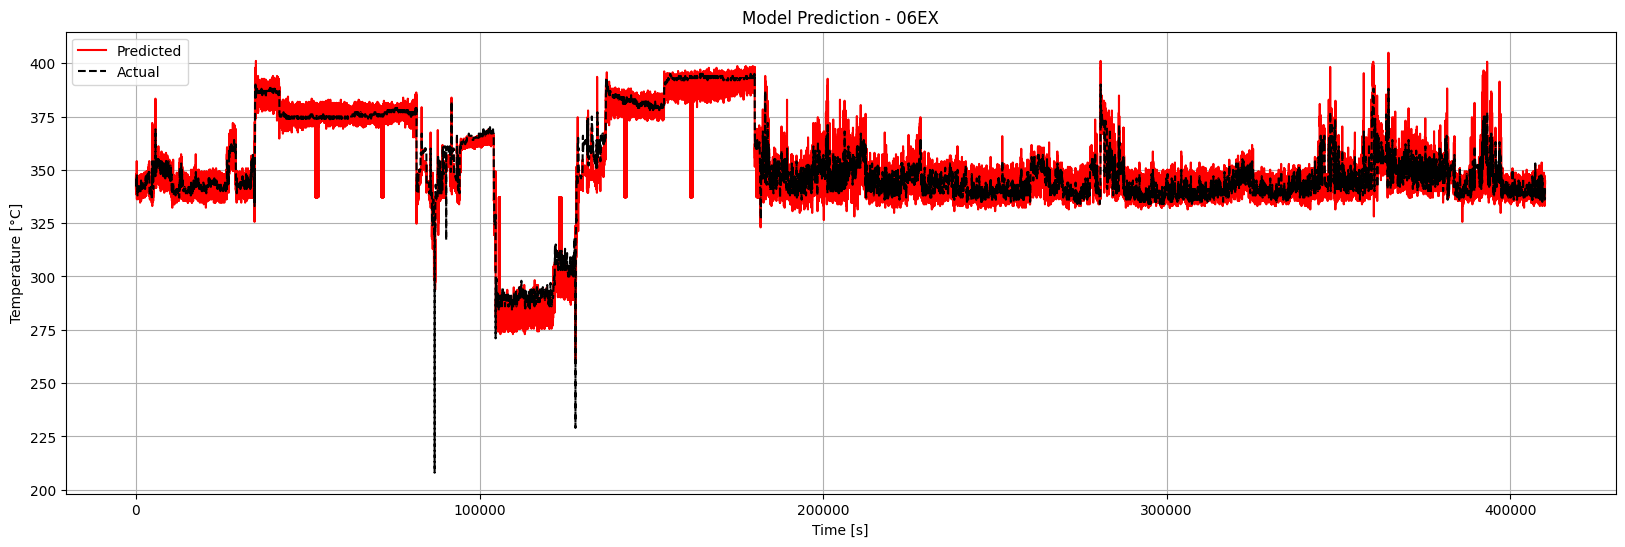


Mean Squared Error: 28.509320276150785
Root Mean Squared Error: 5.339411978500141
Mean Absolute Error: 3.7782540481993325
R-squared: 0.9414996921549738 




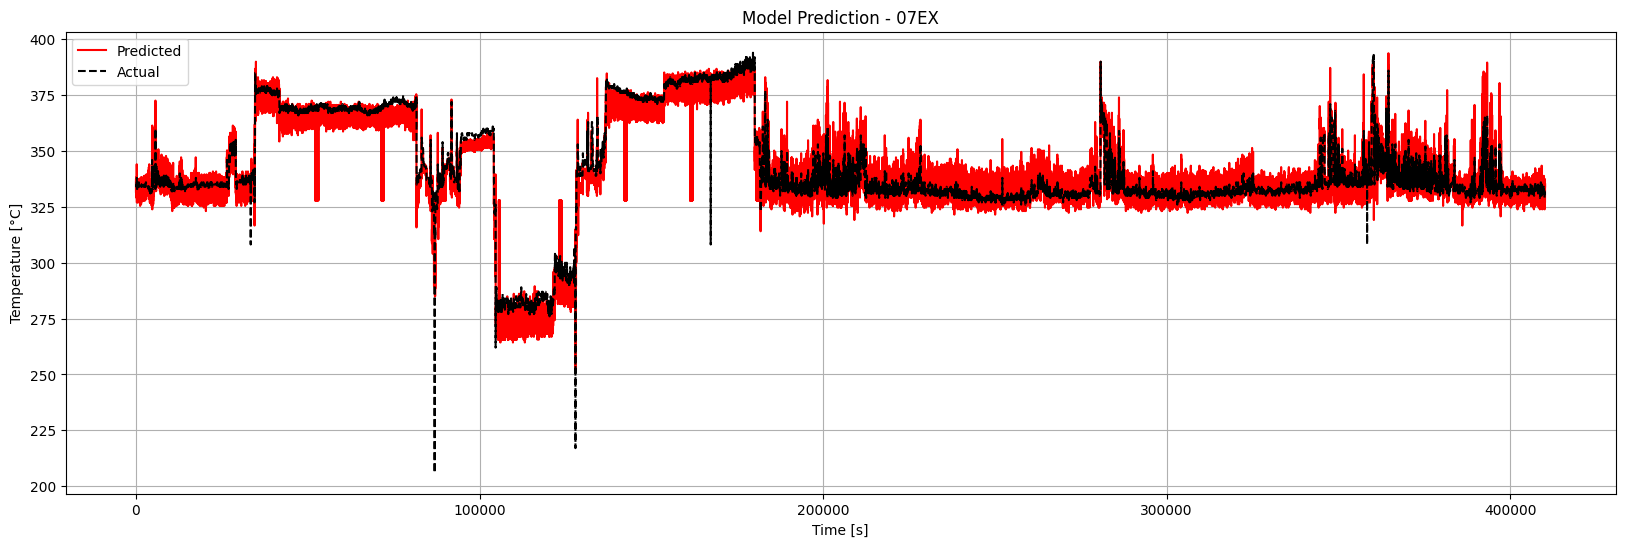


Mean Squared Error: 30.813392780492215
Root Mean Squared Error: 5.550981244833404
Mean Absolute Error: 4.141834290482579
R-squared: 0.9390644987062264 




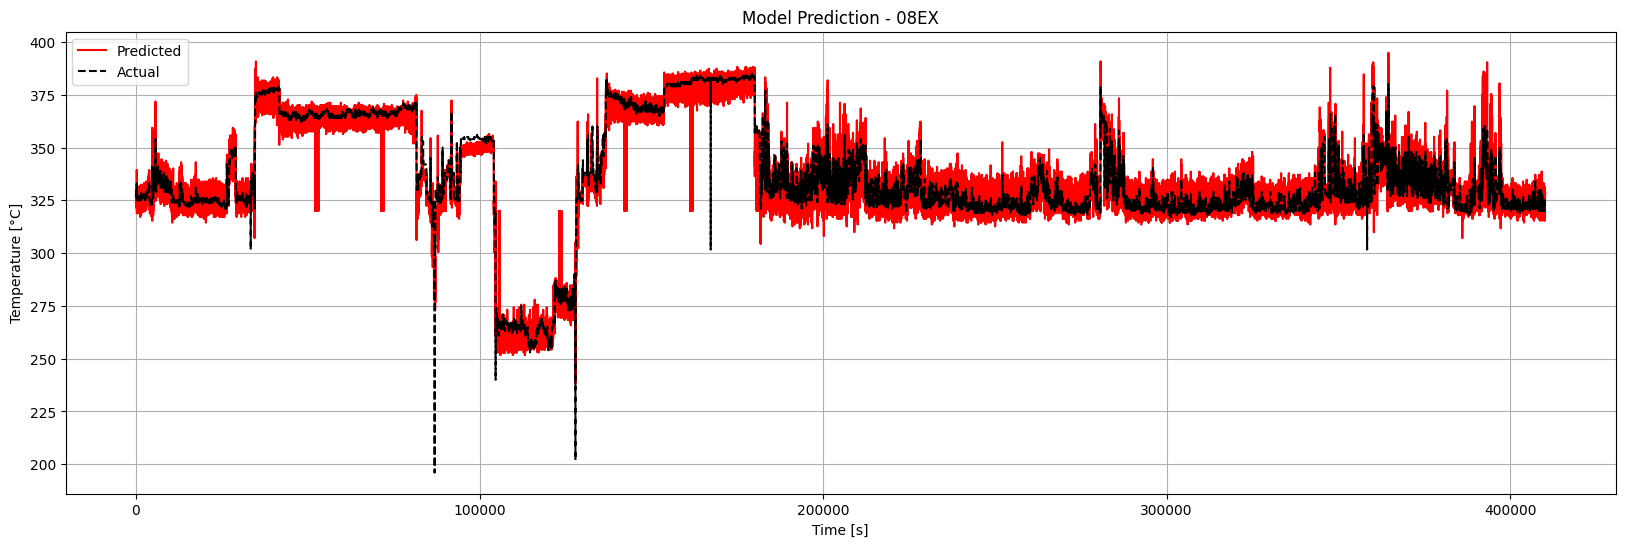


Mean Squared Error: 32.31351514211516
Root Mean Squared Error: 5.684497791548094
Mean Absolute Error: 4.062239182659079
R-squared: 0.9519304352261487 




In [17]:
# Looping through each array of attribute predictions
for i in range(num_attributes_y):

  feature = y_attr[i]

  # Converting attribute predictions and actual values to numpy arrays
  predict = predictions[y_attr.index(feature)]
  actual  = y_test[i]

  # Plotting line graphs for prediction vs. actual
  plt.figure(figsize=(20,6))
  plt.plot(predict, label='Predicted', color='red',   linestyle='-' )
  plt.plot(actual,  label='Actual',    color='black', linestyle='--')

  plt.xlabel('Time [s]')
  plt.ylabel('Temperature [°C]')
  plt.title(f'Model Prediction - {feature}')

  plt.legend()
  plt.grid()
  plt.show()

  # Calculating quantitative accuracy measures
  mse  = mean_squared_error(actual, predict)
  mae  = mean_absolute_error(actual, predict)
  r2   = r2_score(actual, predict)
  rmse = np.sqrt(mse)

  # Printing quantitative accuracy measures
  print(f'\nMean Squared Error: {mse}')
  print(f'Root Mean Squared Error: {rmse}')
  print(f'Mean Absolute Error: {mae}')
  print(f'R-squared: {r2} \n\n')

### Exporting the trained model to the drive

In [16]:
trained_model.model.save(f'{DIR}{DATE}-{VERSION}-{ARCHITECTURE}-{TAG_NAME}.h5')

# TODO

* Bruk konstantene øverst i scriptet til å gjøre filen mer dynamisk
* Sjekk ut andre plot-verktøy enn matplotlib
